
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [1]:
## library imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (accuracy_score,classification_report,f1_score,roc_auc_score
)


In [4]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head()
for c in [0,1,2,3]:
    ha[f"cp_eq_{c}"] = (ha["cp"] == c).astype(int)

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [5]:
X = ha[["trtbps", "chol", "age"]]
y = ha["cp"]   # keeping as integer

In [6]:
knn_clf = Pipeline([
    ("scale_features", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

knn_clf.fit(X, y)

acc_knn = cross_val_score(knn_clf, X, y, cv=5, scoring="accuracy").mean()
f1_knn = cross_val_score(knn_clf, X, y, cv=5, scoring="f1_macro").mean()

acc_knn, f1_knn


(np.float64(0.39191919191919194), np.float64(0.22881172431853275))

In [7]:
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X, y)

cv_tree = cross_val_score(tree_clf, X, y, cv=5, scoring="accuracy").mean()
cv_tree


np.float64(0.41730639730639735)

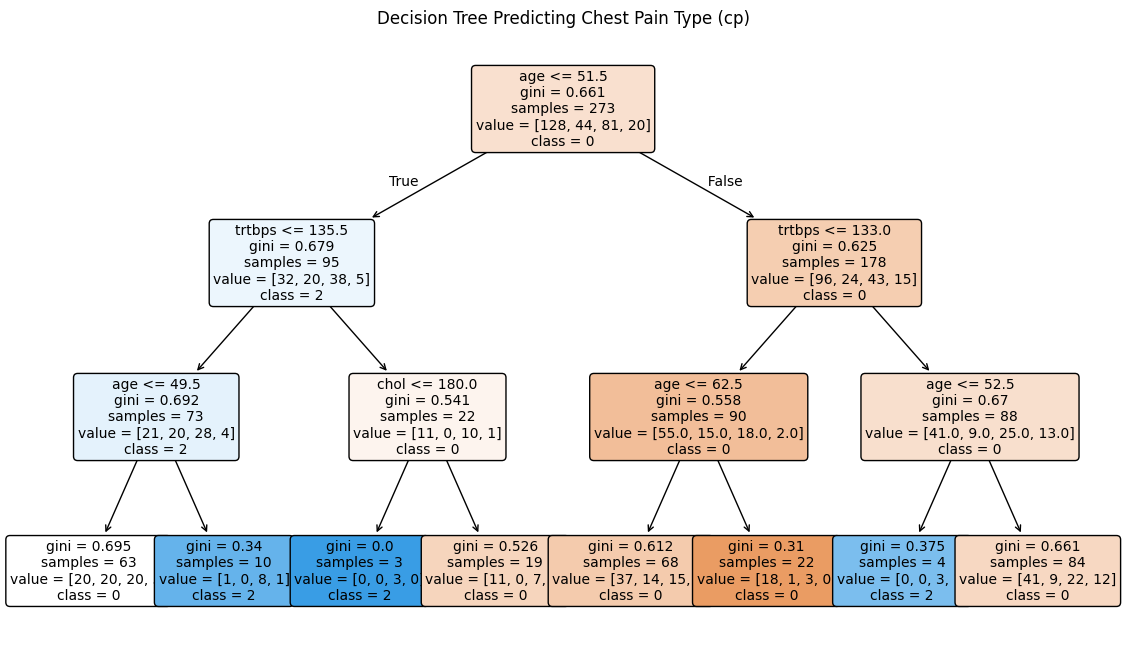

In [10]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plot_tree(
    tree_clf,                         # your existing fitted model
    feature_names=X.columns,          # whatever predictors you used
    class_names=["0", "1", "2", "3"], # cp categories
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Predicting Chest Pain Type (cp)")
plt.show()


The first split in the tree divides patients based on age ≤ 51.5, meaning age is the strongest single factor for separating chest-pain types. Among younger patients, the next split is on resting blood pressure (trtbps ≤ 135.5), while among older patients the next split again uses trtbps (≤ 133.0). This shows that both age and resting blood pressure play the biggest roles in distinguishing between the different chest-pain categories.

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [8]:
ovr_scores = {}

for cls in [0,1,2,3]:
    target = ha[f"cp_eq_{cls}"]
    
    model = Pipeline([
        ("scale", StandardScaler()),
        ("logit", LogisticRegression(max_iter=200))
    ])
    
    f1 = cross_val_score(model, X, target, cv=5, scoring="f1").mean()
    ovr_scores[cls] = f1

ovr_scores


{0: np.float64(0.4624250522492891),
 1: np.float64(0.0),
 2: np.float64(0.0),
 3: np.float64(0.0)}

The OvR model performed best for distinguishing cp = 0, which was the only class with a meaningful F1 score. The other categories were much harder for the model to separate.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [9]:
pairs = [(0,1), (0,2), (0,3)]
auc_results = {}

for a, b in pairs:
    subset = ha[ha["cp"].isin([a, b])].copy()
    
    Xt = subset[["trtbps", "chol", "age"]]
    yt = (subset["cp"] == b).astype(int)
    
    logit_ovo = Pipeline([
        ("scale", StandardScaler()),
        ("logit", LogisticRegression(max_iter=200))
    ])
    
    auc_val = cross_val_score(logit_ovo, Xt, yt, cv=5, scoring="roc_auc").mean()
    auc_results[(a,b)] = auc_val

auc_results


{(0, 1): np.float64(0.6016623931623932),
 (0, 2): np.float64(0.5593246606334841),
 (0, 3): np.float64(0.5585384615384615)}

The OvO approach worked best for the 0 vs 1 comparison, which produced the highest ROC-AUC, meaning those two chest-pain types were the easiest for the model to tell apart.